<a href="https://colab.research.google.com/github/JayaVerma/TEXT-SUMMARIZATION/blob/main/Finetunned_model_with_pegasus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 82.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 18.8 MB/s eta 0:00:0

In [2]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt

import pandas as pd
from datasets import load_dataset

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

from transformers import DataCollatorForSeq2Seq
from transformers import TrainingArguments, Trainer


import pickle

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "google/pegasus-cnn_dailymail"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [4]:
dataset_samsum = load_dataset("samsum")

split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")

print(dataset_samsum["test"][0]["dialogue"])

print("\nSummary:")

print(dataset_samsum["test"][0]["summary"])

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Dataset samsum downloaded and prepared to /root/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


In [5]:
pipe = pipeline('summarization', model = model_ckpt )

pipe_out = pipe(dataset_samsum['test'][0]['dialogue'] )

print(pipe_out)


Your max_length is set to 128, but you input_length is only 122. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


[{'summary_text': "Amanda: Ask Larry Amanda: He called her last time we were at the park together .<n>Hannah: I'd rather you texted him .<n>Amanda: Just text him ."}]


Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


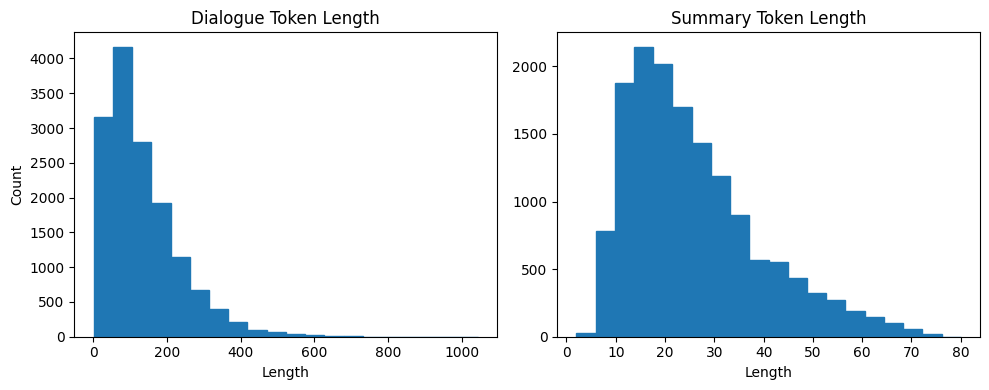

In [6]:
dialogue_token_len = [len(tokenizer.encode(s)) for s in dataset_samsum['train']['dialogue'] ]

summary_token_len = [len(tokenizer.encode(s)) for s in dataset_samsum['train']['summary'] ]

fig, axes = plt.subplots(1, 2, figsize=(10, 4) )
axes[0].hist(dialogue_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [7]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'] , max_length = 1024, truncation = True )
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True )
        
    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }
    
dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [8]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

In [9]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
) 

In [10]:
trainer = Trainer(model=model_pegasus, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"], 
                  eval_dataset=dataset_samsum_pt["validation"])

In [11]:

trainer.train()


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
500,1.704100,1.482772


TrainOutput(global_step=920, training_loss=1.8294374973877616, metrics={'train_runtime': 1861.2074, 'train_samples_per_second': 7.915, 'train_steps_per_second': 0.494, 'total_flos': 5526961323663360.0, 'train_loss': 1.8294374973877616, 'epoch': 1.0})

In [12]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}

sample_text = dataset_samsum["test"][136]["dialogue"]

reference = dataset_samsum["test"][136]["summary"]

pipe = pipeline("summarization", model="transformersbook/pegasus-samsum")

## 
print("Dialogue:")
print(sample_text)


print("\nReference Summary:")
print(reference)


print("\nModel Summary:")
model_sum = pipe(sample_text, **gen_kwargs)[0]["summary_text"]
print(model_sum)

Dialogue:
Marty: Hiya, I have a favour to ask... can you pick up Marcel from school?
Christine: Sure, you ok?
Marty: Not really, I think I have sprained my ankle...
Christine: Oh no, have you seen see a doctor?
Marty: I was gonna see how it went today and might go tomorrow...
Christine: Are you sure? I'm happy to take you now if you want?
Marty: Nah, it can wait, that'll leave us in trouble with the kids...
Christine: OK, I'll pick up Marcel then.
Christine: Do you need anything from the shops or something?
Marty: No we are good thanks. we'll have pizza night, Marcel can sort us out...
Christine: I'm on a late shift tomorrow, shall I take Marcel in tomorrow morning? I'll take you to the doctor afterwards if you want?
Marty: That would be awesome, thank you for your help...
Christine: No problem, you'll have to call the school though.
Marty: Good one, will do that now...
Christine: See you around 4.
Marty: Thank you so much!

Reference Summary:
Marty thinks she has sprained her ankle. M

In [13]:
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
from rouge import Rouge
ROUGE =Rouge()
ref_rough = ROUGE.get_scores(reference, sample_text)
ref_rough

[{'rouge-1': {'r': 0.17592592592592593,
   'p': 0.6551724137931034,
   'f': 0.27737225943630456},
  'rouge-2': {'r': 0.05555555555555555,
   'p': 0.21428571428571427,
   'f': 0.08823529084775099},
  'rouge-l': {'r': 0.17592592592592593,
   'p': 0.6551724137931034,
   'f': 0.27737225943630456}}]

In [15]:
model_rough = ROUGE.get_scores(model_sum, sample_text)
model_rough

[{'rouge-1': {'r': 0.16666666666666666,
   'p': 0.6428571428571429,
   'f': 0.26470587908304505},
  'rouge-2': {'r': 0.024691358024691357,
   'p': 0.13793103448275862,
   'f': 0.041884814178339565},
  'rouge-l': {'r': 0.14814814814814814,
   'p': 0.5714285714285714,
   'f': 0.23529411437716266}}]

In [16]:
sample_text467 = dataset_samsum["test"][467]["dialogue"]

reference467 = dataset_samsum["test"][467]["summary"]

## 
print("Dialogue:")
print(sample_text467)


print("\nReference Summary:")
print(reference467)


print("\nModel Summary:")
model_sum467 = pipe(sample_text467, **gen_kwargs)[0]["summary_text"]
print(model_sum467)

print("\nReference Summary Rough Value:")
ref_rough467 = ROUGE.get_scores(reference467, sample_text467)
print(ref_rough467)

print("\nModel Summary Rough Value:")
model_rough467 = ROUGE.get_scores(model_sum467, sample_text467)
print(model_rough467)

Dialogue:
Derek McCarthy: Filip - are you around? Would you have an Android cable I could borrow for an hour? I'm almost out of charge and I have a power pack  but forgot my cable😭
Tommy: I am in Poland but can ring my wife and she will give you one
Tommy: Do you want me to?
Tommy: 67 glenoaks close
Derek McCarthy: That would be great if you could!! Otherwise I'm sitting here in the dark for an hour <emoticon_smile>
Tommy: Put it in gps and start driving
Derek McCarthy: <emoticon_thumbup>
Tommy: She might be at work for next 15 min but will help you for sure
Derek McCarthy: Thanks a lot mate
Tommy: Sent her msg. She will give it to you. Approx time when she will be at home is 8:15 pm
Derek McCarthy: Thanks again!! What's your wife's name  again??
Tommy: Paulina

Reference Summary:
Derek McCarthy will pick up an Android cable from Tommy's wife at 8:15.

Model Summary:
Derek McCarthy needs to borrow an Android cable for an hour. Tommy's wife will give him one. Tommy will be at work for 1

In [17]:
sample_text818 = dataset_samsum["test"][818]["dialogue"]

reference818 = dataset_samsum["test"][818]["summary"]

## 
print("Dialogue:")
print(sample_text818)


print("\nReference Summary:")
print(reference818)


print("\nModel Summary:")
model_sum818 = pipe(sample_text818, **gen_kwargs)[0]["summary_text"]
print(model_sum818)

print("\nReference Summary Rough Value:")
ref_rough818 = ROUGE.get_scores(reference818, sample_text818)
print(ref_rough818)

print("\nModel Summary Rough Value:")
model_rough818 = ROUGE.get_scores(model_sum818, sample_text818)
print(model_rough818)

Dialogue:
Rachel: <file_other>
Rachel: Top 50 Best Films of 2018
Rachel: :)
Janice: Omg, I've watched almost all 50... xDD
Spencer: Hahah, Deadpool 2 also??
Janice: Yep
Spencer: Really??
Janice: My bf forced me to watch it xD
Rachel: Hahah
Janice: It wasn't that bad
Janice: I thought it'd be worse
Rachel: And Avengers? :D
Janice: 2 times
Rachel: Omg
Janice: xP
Rachel: You are the best gf in the world
Rachel: Your bf should appreciate that ;-)
Janice: He does
Janice: x)

Reference Summary:
Rachel sends a list of Top 50 films of 2018. Janice watched almost half of them, Deadpool 2 and Avengers included.

Model Summary:
Janice has watched almost all the films in the Top 50 Best Films of 2018 list. Her boyfriend forced her to watch Deadpool 2 and Avengers. She's the best girlfriend in the world.

Reference Summary Rough Value:
[{'rouge-1': {'r': 0.13114754098360656, 'p': 0.42105263157894735, 'f': 0.19999999637812504}, 'rouge-2': {'r': 0.04938271604938271, 'p': 0.2, 'f': 0.07920791761592014

In [18]:
sample_text54 = dataset_samsum["test"][54]["dialogue"]

reference54 = dataset_samsum["test"][54]["summary"]

## 
print("Dialogue:")
print(sample_text54)


print("\nReference Summary:")
print(reference54)


print("\nModel Summary:")
model_sum54 = pipe(sample_text54, **gen_kwargs)[0]["summary_text"]
print(model_sum54)

print("\nReference Summary Rough Value:")
ref_rough54 = ROUGE.get_scores(reference54, sample_text54)
print(ref_rough54)

print("\nModel Summary Rough Value:")
model_rough54 = ROUGE.get_scores(model_sum54, sample_text54)
print(model_rough54)

Your max_length is set to 128, but you input_length is only 67. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Dialogue:
Craig: Man, u there?
Derek: Yeah, tell me
Craig: I need help with my computer
Derek: What happened?
Craig: I don't know exactly but it's not working
Derek: Well, ok... give me 20 minutes, got to get to my car
Craig: Ok, thanks
Derek: No prob

Reference Summary:
Derek will be at Craig's in 20 minutes to help him with his malfunctioning computer.

Model Summary:
Craig needs help with his computer. Derek will get to Craig's car in 20 minutes and help him with his computer. He doesn't know exactly what happened but it's not working.

Reference Summary Rough Value:
[{'rouge-1': {'r': 0.1388888888888889, 'p': 0.3333333333333333, 'f': 0.19607842722029997}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.1388888888888889, 'p': 0.3333333333333333, 'f': 0.19607842722029997}}]

Model Summary Rough Value:
[{'rouge-1': {'r': 0.3611111111111111, 'p': 0.48148148148148145, 'f': 0.4126984078004535}, 'rouge-2': {'r': 0.13636363636363635, 'p': 0.21428571428571427, 'f': 0.166666661

In [19]:
sample_text365 = dataset_samsum["test"][365]["dialogue"]

reference365 = dataset_samsum["test"][365]["summary"]

## 
print("Dialogue:")
print(sample_text365)


print("\nReference Summary:")
print(reference365)


print("\nModel Summary:")
model_sum365 = pipe(sample_text365, **gen_kwargs)[0]["summary_text"]
print(model_sum365)

print("\nReference Summary Rough Value:")
ref_rough365 = ROUGE.get_scores(reference365, sample_text365)
print(ref_rough365)

print("\nModel Summary Rough Value:")
model_rough365 = ROUGE.get_scores(model_sum365, sample_text365)
print(model_rough365)

Your max_length is set to 128, but you input_length is only 90. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Dialogue:
Sean: Hey, I won't be able to take the car to the carwash
Sean: They want me to finish report first :(
Alice: shoot, but it's crazily dirty
Alice: Will we have tomorrow?
Sean: <file_gif>
Sean: We can leave a bit earlier or get it washed somewhere on the road
Alice: it might be  good idea, let's do it tomorrow then
Sean: great!

Reference Summary:
Alice and Sean will wash the car on their way tomorrow.

Model Summary:
Sean won't be able to take the car to the carwash tomorrow because it's dirty. Alice and Sean are going to wash the car tomorrow.

Reference Summary Rough Value:
[{'rouge-1': {'r': 0.08, 'p': 0.36363636363636365, 'f': 0.13114753802741205}, 'rouge-2': {'r': 0.016129032258064516, 'p': 0.1, 'f': 0.027777775385802676}, 'rouge-l': {'r': 0.08, 'p': 0.36363636363636365, 'f': 0.13114753802741205}}]

Model Summary Rough Value:
[{'rouge-1': {'r': 0.22, 'p': 0.6111111111111112, 'f': 0.3235294078719724}, 'rouge-2': {'r': 0.14516129032258066, 'p': 0.391304347826087, 'f': 0.21

In [20]:
sample_text210 = dataset_samsum["test"][210]["dialogue"]

reference210 = dataset_samsum["test"][210]["summary"]

## 
print("Dialogue:")
print(sample_text210)


print("\nReference Summary:")
print(reference210)


print("\nModel Summary:")
model_sum210 = pipe(sample_text210, **gen_kwargs)[0]["summary_text"]
print(model_sum210)

print("\nReference Summary Rough Value:")
ref_rough210 = ROUGE.get_scores(reference210, sample_text210)
print(ref_rough210)

print("\nModel Summary Rough Value:")
model_rough210 = ROUGE.get_scores(model_sum210, sample_text210)
print(model_rough210)

Your max_length is set to 128, but you input_length is only 108. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Dialogue:
Yaz: Going to slimming club tonight?
Mary: Well, I don't want to, but I really should. I've been so bad, though!
Yaz: Me too, choccies, wine, cake, you name it!
Mary: Well, we should bite the bullet. She'll tell us off, I expect. Feels like being back at school!
Yaz: Well, she IS our old cookery teacher! See you at 6ish, pick you up!?
Mary: Yep! See you then!

Reference Summary:
Yaz and Mary are meeting tonight around 6 and going for the slimming club together. They expect to be scolded for eating too much. 

Model Summary:
Yaz and Mary are going to a slimming club tonight. They are going to meet at 6ish. They are going to meet Yaz's cookery teacher.

Reference Summary Rough Value:
[{'rouge-1': {'r': 0.09090909090909091, 'p': 0.21739130434782608, 'f': 0.12820512404667997}, 'rouge-2': {'r': 0.015151515151515152, 'p': 0.041666666666666664, 'f': 0.022222218311111798}, 'rouge-l': {'r': 0.09090909090909091, 'p': 0.21739130434782608, 'f': 0.12820512404667997}}]

Model Summary Rough

In [21]:
sample_text629 = dataset_samsum["test"][629]["dialogue"]

reference629 = dataset_samsum["test"][629]["summary"]

## 
print("Dialogue:")
print(sample_text629)


print("\nReference Summary:")
print(reference629)


print("\nModel Summary:")
model_sum629 = pipe(sample_text629, **gen_kwargs)[0]["summary_text"]
print(model_sum629)

print("\nReference Summary Rough Value:")
ref_rough629 = ROUGE.get_scores(reference629, sample_text629)
print(ref_rough629)

print("\nModel Summary Rough Value:")
model_rough629 = ROUGE.get_scores(model_sum629, sample_text629)
print(model_rough629)

Your max_length is set to 128, but you input_length is only 70. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Dialogue:
Mummy: My dearest Thess and Mike! We wish you God's blessing and a happy celebration of Christmas! Our thoughts are with you every second today.
Thessalia: We are joining you in prayer and our hearts are celebrating Christmas with you. May joy and peace be with you all!
Mummy: So help us God.

Reference Summary:
Mummy and Thessalia send Christmas greetings to each other.

Model Summary:
Thessalia and Mike are joining Mummy and Mike in prayer for a happy Christmas. They wish them God's blessing and a happy celebration of Christmas.

Reference Summary Rough Value:
[{'rouge-1': {'r': 0.05, 'p': 0.2222222222222222, 'f': 0.0816326500624741}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.05, 'p': 0.2222222222222222, 'f': 0.0816326500624741}}]

Model Summary Rough Value:
[{'rouge-1': {'r': 0.325, 'p': 0.6842105263157895, 'f': 0.4406779617351337}, 'rouge-2': {'r': 0.16, 'p': 0.36363636363636365, 'f': 0.22222221797839511}, 'rouge-l': {'r': 0.325, 'p': 0.684210526315789

In [22]:
sample_text501 = dataset_samsum["test"][501]["dialogue"]

reference501 = dataset_samsum["test"][501]["summary"]

## 
print("Dialogue:")
print(sample_text501)


print("\nReference Summary:")
print(reference501)


print("\nModel Summary:")
model_sum501 = pipe(sample_text501, **gen_kwargs)[0]["summary_text"]
print(model_sum501)

print("\nReference Summary Rough Value:")
ref_rough501 = ROUGE.get_scores(reference501, sample_text501)
print(ref_rough501)

print("\nModel Summary Rough Value:")
model_rough501 = ROUGE.get_scores(model_sum501, sample_text501)
print(model_rough501)

Dialogue:
Ricky: Did u guys see what's going on outside?
Shelly: A real blizzard!
Tom: Haven't seen such weather in yrs!
Ricky: This reminds me of a time when I was hiking in the mountains.
Shelly: U went hiking?
Tom: Yeah. What's so weird about it?
Ricky: U don't strike us as the type.
Tom: Well, I did. It was a couple yrs back, I admit. I was still a student and we went as a group of friends to the mountains.
Shelly: How many of u were there?
Tom: I think 5 or 6. Myself included.
Ricky: So what happened?
Tom: We rented a cabin in the wild. We wanted to have a weekend away.

Reference Summary:
There is a blizzard going on outside. Ricky went hiking a couple years ago with friends. They rented a cabin in the wild.

Model Summary:
Tom went hiking in the mountains with a group of friends a couple years ago. They rented a cabin in the wild and wanted to have a weekend away.

Reference Summary Rough Value:
[{'rouge-1': {'r': 0.14814814814814814, 'p': 0.5714285714285714, 'f': 0.235294114377

In [23]:
sample_text784 = dataset_samsum["test"][784]["dialogue"]

reference784 = dataset_samsum["test"][784]["summary"]

## 
print("Dialogue:")
print(sample_text784)


print("\nReference Summary:")
print(reference784)


print("\nModel Summary:")
model_sum784 = pipe(sample_text784, **gen_kwargs)[0]["summary_text"]
print(model_sum784)

print("\nReference Summary Rough Value:")
ref_rough784 = ROUGE.get_scores(reference784, sample_text784)
print(ref_rough784)

print("\nModel Summary Rough Value:")
model_rough784 = ROUGE.get_scores(model_sum784, sample_text784)
print(model_rough784)

Dialogue:
Margaret: Hi, in December I'd like to meet on 4th and 11th around 10:00 or 11:00. 
Evans: Hi, 4th - we can meet at 10:00.
Evans: And 11th - at 11:00. 
Margaret: Okey. And what about 18th?
Evans: I'm not sure about 18th. 
Evans: I might not be in town. 
Margaret: Okey, so we'll see. 
Evans: Yes. And I'll let you know next week. 
Margaret: If it's not 18th, maybe we could meet on 17th?
Evans: If I go away, I won't also be 17th.
Margaret: Okey, I get it. 
Evans: But we could meet 14th, if you like?
Margaret: Hm, I'm not sure whether I'm avaliable. 
Evans: So let's set these dates later, ok?
Margaret: Okey and we see each other 4th 10:00. 
Evans: Yes!

Reference Summary:
Margaret and Evans plan to meet at 10 on 4th and at 11 on 11th. They both are not sure when they will be able to meet next, so they will come up with a date later.

Model Summary:
Margaret and Evans will meet on 4th and 11th around 10:00 or 11:00. Evans might not be in town on 18th. They might meet on 17th.

Refe

In [26]:
sample_text = '''The Dursleys had everything they wanted, but they also had a secret, and
their greatest fear was that somebody would discover it. They didn't
think they could bear it if anyone found out about the Potters. Mrs.
Potter was Mrs. Dursley's sister, but they hadn't met for several years;
in fact, Mrs. Dursley pretended she didn't have a sister, because her
sister and her good-for-nothing husband were as unDursleyish as it was
possible to be. The Dursleys shuddered to think what the neighbors would
say if the Potters arrived in the street. The Dursleys knew that the
Potters had a small son, too, but they had never even seen him. This boy
was another good reason for keeping the Potters away; they didn't want
Dudley mixing with a child like that'''

#reference784 = dataset_samsum["test"][784]["summary"]

## 
print("Dialogue:")
print(sample_text)


##print("\nReference Summary:")
##print(reference784)


print("\nModel Summary:")
model_sum = pipe(sample_text, **gen_kwargs)[0]["summary_text"]
print(model_sum)

# print("\nReference Summary Rough Value:")
# ref_rough784 = ROUGE.get_scores(reference784, sample_text784)
# print(ref_rough784)

print("\nModel Summary Rough Value:")
model_rough = ROUGE.get_scores(model_sum, sample_text)
print(model_rough)

Dialogue:
The Dursleys had everything they wanted, but they also had a secret, and
their greatest fear was that somebody would discover it. They didn't
think they could bear it if anyone found out about the Potters. Mrs.
Potter was Mrs. Dursley's sister, but they hadn't met for several years;
in fact, Mrs. Dursley pretended she didn't have a sister, because her
sister and her good-for-nothing husband were as unDursleyish as it was
possible to be. The Dursleys shuddered to think what the neighbors would
say if the Potters arrived in the street. The Dursleys knew that the
Potters had a small son, too, but they had never even seen him. This boy
was another good reason for keeping the Potters away; they didn't want
Dudley mixing with a child like that

Model Summary:
Mrs. Potter was Mrs. Dursley's sister, but they hadn't met for several years. Mrs. Dursley pretended she didn't have a sister because her sister and her good-for-nothing husband were unDursleyish.

Model Summary Rough Value:
[

In [27]:
sample_text = '''She came out of the research assistant’s room with her microeconomics quiz 
results. She walked past the queued up students toward me. By this time, 
everyone on campus knew of her friendship, or as someone would say, 
siblingship, with me. She wore denim shorts and a pink T-shirt, drawing extra 
long glances from the boys from engineering colleges. 
 ‘B-plus, people say it is a good grade,’ she said, holding up her answer sheet. 
 ‘Your shorts are too short,’ I said. 
 ‘Show me your grade,’ she said, snatching my paper. ‘A minus, wow, you 
cracked an A-minus!’ 
 I didn’t react. We walked back towards our dorms. 
 ‘You cannot score more than me in economics, I don’t believe this,’ she said. 
‘You are a mechanical engineer. I am a university gold medalist in the subject.’ 
 ‘Show the medal to Prof Chatterjee,’ I said in a serious tone.'''

#reference784 = dataset_samsum["test"][784]["summary"]

## 
print("Dialogue:")
print(sample_text)


##print("\nReference Summary:")
##print(reference784)


print("\nModel Summary:")
model_sum = pipe(sample_text, **gen_kwargs)[0]["summary_text"]
print(model_sum)

# print("\nReference Summary Rough Value:")
# ref_rough784 = ROUGE.get_scores(reference784, sample_text784)
# print(ref_rough784)

print("\nModel Summary Rough Value:")
model_rough = ROUGE.get_scores(model_sum, sample_text)
print(model_rough)

Dialogue:
She came out of the research assistant’s room with her microeconomics quiz 
results. She walked past the queued up students toward me. By this time, 
everyone on campus knew of her friendship, or as someone would say, 
siblingship, with me. She wore denim shorts and a pink T-shirt, drawing extra 
long glances from the boys from engineering colleges. 
 ‘B-plus, people say it is a good grade,’ she said, holding up her answer sheet. 
 ‘Your shorts are too short,’ I said. 
 ‘Show me your grade,’ she said, snatching my paper. ‘A minus, wow, you 
cracked an A-minus!’ 
 I didn’t react. We walked back towards our dorms. 
 ‘You cannot score more than me in economics, I don’t believe this,’ she said. 
‘You are a mechanical engineer. I am a university gold medalist in the subject.’ 
 ‘Show the medal to Prof Chatterjee,’ I said in a serious tone.

Model Summary:
She came out of the research assistant's room with her microeconomics quiz results. She wore denim shorts and a pink T-shirt, d

In [28]:
sample_text = '''‘Nothing. I want you to consider the possibility that women are intelligent 
human beings. And intelligent people don’t like to be told what to wear or do, 
especially when they are adults. Does that make any sense to you?’ 
 ‘Don’t be over-smart,’ I said. 
 ‘Don’t patronize me,’ she said. 
 ‘There are other ways to attract attention than by wearing less clothes,’ I said. 
 ‘I didn’t do it to attract attention. I wear shorts because I like to wear shorts.’ 
 ‘Can we study?’ I opened the case again. 
 We kept quiet for half an hour and immersed ourselves in our books. 
 ‘I wasn’t trying to attract attention,’ she said again, looking up from her books. 
 ‘It doesn’t matter to me,’ I said. 
 ‘Are you jealous?’ 
 ‘Are you kidding me?’ I slammed my book shut. 
 ‘No, just checking. Let’s study.’ She turned back to her books, a smile on her 
face.'''

#reference784 = dataset_samsum["test"][784]["summary"]

## 
print("Dialogue:")
print(sample_text)


##print("\nReference Summary:")
##print(reference784)


print("\nModel Summary:")
model_sum = pipe(sample_text, **gen_kwargs)[0]["summary_text"]
print(model_sum)

# print("\nReference Summary Rough Value:")
# ref_rough784 = ROUGE.get_scores(reference784, sample_text784)
# print(ref_rough784)

print("\nModel Summary Rough Value:")
model_rough = ROUGE.get_scores(model_sum, sample_text)
print(model_rough)

Dialogue:
‘Nothing. I want you to consider the possibility that women are intelligent 
human beings. And intelligent people don’t like to be told what to wear or do, 
especially when they are adults. Does that make any sense to you?’ 
 ‘Don’t be over-smart,’ I said. 
 ‘Don’t patronize me,’ she said. 
 ‘There are other ways to attract attention than by wearing less clothes,’ I said. 
 ‘I didn’t do it to attract attention. I wear shorts because I like to wear shorts.’ 
 ‘Can we study?’ I opened the case again. 
 We kept quiet for half an hour and immersed ourselves in our books. 
 ‘I wasn’t trying to attract attention,’ she said again, looking up from her books. 
 ‘It doesn’t matter to me,’ I said. 
 ‘Are you jealous?’ 
 ‘Are you kidding me?’ I slammed my book shut. 
 ‘No, just checking. Let’s study.’ She turned back to her books, a smile on her 
face.

Model Summary:
She doesn't like to be told what to wear or do, especially when she is an adult. She doesn't wear shorts because she like

In [29]:
sample_text = '''‘You OK?’ I said going up to my just friend. She remained in her seat as her 
tears re-emerged. The last lecture had ended and the classroom was empty. 
 I hadn’t spoken much to Ananya after our lunch last week. Pretty girls behave 
best when you ignore them. (Of course, they have to know you are ignoring them, 
for otherwise they may not even know you exist.) 
 But today I had to talk to her. She had cried in the class. We had auditorium-
style classrooms with semi-circular rows, so everyone could see everyone. 
Students sat in alphabetical order. Ananya, like all kids doomed with names 
starting with the letter A, sat in the first row on the left side. She sat between 
Ankur and Aditya, both IITians who had already proposed to her without 
considering the embarrassment of being rejected and then sitting next to the 
rejection for the whole year. 
 I sat in the third row, between Kanyashree, who took notes like a diligent court 
transcripter, and five Mohits, who had come from different parts of India. But 
neither Ankur, nor Kanyashree, nor the five Mohits had noticed Ananya’s tears. 
Only I had caught her wiping her eye with a yellow dupatta that had little bells at 
its ends that tinkled whenever she moved. 
 In the past week, I had limited my communication with Ananya to cursory 
greetings every morning and a casual wave at the end of the day. During classes 
we had to pay attention to the teachers we had marks for class participation-
saying something that sounds intelligent. Most IITians never spoke while people 
from non-science backgrounds spoke non-stop.
'''

#reference784 = dataset_samsum["test"][784]["summary"]

## 
print("Dialogue:")
print(sample_text)


##print("\nReference Summary:")
##print(reference784)


print("\nModel Summary:")
model_sum = pipe(sample_text, **gen_kwargs)[0]["summary_text"]
print(model_sum)

# print("\nReference Summary Rough Value:")
# ref_rough784 = ROUGE.get_scores(reference784, sample_text784)
# print(ref_rough784)

print("\nModel Summary Rough Value:")
model_rough = ROUGE.get_scores(model_sum, sample_text)
print(model_rough)

Dialogue:
‘You OK?’ I said going up to my just friend. She remained in her seat as her 
tears re-emerged. The last lecture had ended and the classroom was empty. 
 I hadn’t spoken much to Ananya after our lunch last week. Pretty girls behave 
best when you ignore them. (Of course, they have to know you are ignoring them, 
for otherwise they may not even know you exist.) 
 But today I had to talk to her. She had cried in the class. We had auditorium-
style classrooms with semi-circular rows, so everyone could see everyone. 
Students sat in alphabetical order. Ananya, like all kids doomed with names 
starting with the letter A, sat in the first row on the left side. She sat between 
Ankur and Aditya, both IITians who had already proposed to her without 
considering the embarrassment of being rejected and then sitting next to the 
rejection for the whole year. 
 I sat in the third row, between Kanyashree, who took notes like a diligent court 
transcripter, and five Mohits, who had come fr

In [30]:
sample_text = ''' [6:36 pm, 31/03/2023] Yash Mestry RGIT: Hello maam 
We have completed coding of all our 5 models last week , but we are facing an issue we are unable to subscribe to the Google Pro , because Payment can only be done through visa card and it's not happening. that's why can't run all our models and get the outputs. Our research paper is also almost ready just output of all models remaining to append in the report.
[6:38 pm, 31/03/2023] Poonam Ma'am RGIT: You can use yr family members or friends visa card to do the payment.. otherwise till the end you will be giving the same reason
[6:38 pm, 31/03/2023] Poonam Ma'am RGIT: With out yr implementation and results,how you can publish paper? Without that yr project hard copy can't be signed
[6:38 pm, 31/03/2023] Sweta Kumari: Mam we have tried almost 10...15 cards
[6:40 pm, 31/03/2023] Jaya Verma: Yes maam
[6:42 pm, 31/03/2023] Yash Mestry RGIT: Yes maam
[6:48 pm, 31/03/2023] Poonam Ma'am RGIT: I have just talked with my PhD student Shahista..She told that she will help you in that..Just call her
[6:48 pm, 31/03/2023] Poonam Ma'am RGIT: Shaista Phd Student
[6:48 pm, 31/03/2023] Jaya Verma: Okay ma'am
[8:50 pm, 01/04/2023] Poonam Ma'am RGIT: Keep your paper soft copy and Project report soft copy ready by Monday and show it to me on Monday.
[3:07 pm, 03/04/2023] Jaya Verma: Hello ma'am
[3:09 pm, 03/04/2023] Jaya Verma: We are constantly try 
We have resolved the problem of buying the subscription. 
And fine tunned tow models 
Pegasus and SimpleT5

But we are facing unexpected errors We also tried to find out way to resolve it but did resolved it yet.

I have also contacted Shaista for the same and waiting for her to reply.
'''

#reference784 = dataset_samsum["test"][784]["summary"]

## 
print("Dialogue:")
print(sample_text)


##print("\nReference Summary:")
##print(reference784)


print("\nModel Summary:")
model_sum = pipe(sample_text, **gen_kwargs)[0]["summary_text"]
print(model_sum)

# print("\nReference Summary Rough Value:")
# ref_rough784 = ROUGE.get_scores(reference784, sample_text784)
# print(ref_rough784)

print("\nModel Summary Rough Value:")
model_rough = ROUGE.get_scores(model_sum, sample_text)
print(model_rough)

Dialogue:
 [6:36 pm, 31/03/2023] Yash Mestry RGIT: Hello maam 
We have completed coding of all our 5 models last week , but we are facing an issue we are unable to subscribe to the Google Pro , because Payment can only be done through visa card and it's not happening. that's why can't run all our models and get the outputs. Our research paper is also almost ready just output of all models remaining to append in the report.
[6:38 pm, 31/03/2023] Poonam Ma'am RGIT: You can use yr family members or friends visa card to do the payment.. otherwise till the end you will be giving the same reason
[6:38 pm, 31/03/2023] Poonam Ma'am RGIT: With out yr implementation and results,how you can publish paper? Without that yr project hard copy can't be signed
[6:38 pm, 31/03/2023] Sweta Kumari: Mam we have tried almost 10...15 cards
[6:40 pm, 31/03/2023] Jaya Verma: Yes maam
[6:42 pm, 31/03/2023] Yash Mestry RGIT: Yes maam
[6:48 pm, 31/03/2023] Poonam Ma'am RGIT: I have just talked with my PhD student

In [ ]:
import pickle
pickle.dump(pipe, open('model.pkl','wb'))
model = pickle.load(open('model.pkl', 'rb'))
text = """Marty: Hiya, I have a favour to ask... can you pick up Marcel from school?
Christine: Sure, you ok?
Marty: Not really, I think I have sprained my ankle...
Christine: Oh no, have you seen see a doctor?
Marty: I was gonna see how it went today and might go tomorrow...
Christine: Are you sure? I'm happy to take you now if you want?
Marty: Nah, it can wait, that'll leave us in trouble with the kids...
Christine: OK, I'll pick up Marcel then.
Christine: Do you need anything from the shops or something?
Marty: No we are good thanks. we'll have pizza night, Marcel can sort us out...
Christine: I'm on a late shift tomorrow, shall I take Marcel in tomorrow morning? I'll take you to the doctor afterwards if you want?
Marty: That would be awesome, thank you for your help...
Christine: No problem, you'll have to call the school though.
Marty: Good one, will do that now...
Christine: See you around 4.
Marty: Thank you so much! """
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
model_sum = model(text, **gen_kwargs)[0]["summary_text"]
print(model_sum)